<a href="https://colab.research.google.com/github/leohsuofnthu/Pytorch-TextCNN/blob/master/textCNN_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re


import pandas as pd
from numpy.random import RandomState

import torchtext
from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.vocab import GloVe
from torchtext.data import Iterator, BucketIterator
import torchtext.datasets
from torchtext.datasets import IMDB, SST

import spacy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [0]:
#%% Split whole dataset into train and valid set
df = pd.read_csv('./IMDB_Dataset.csv')
rng = RandomState()

tr = df.sample(frac=0.7, random_state=rng)
tst = df.loc[~df.index.isin(tr.index)]
tr.to_csv('train.csv', index=False)
tst.to_csv('valid.csv', index=False)

In [0]:
#%% Prepare the dataset via torchtext
spacy_en = spacy.load('en', disable=['tagger', 'parser', 'ner', 'textcat'
                                     'entity_ruler', 'sentencizer', 
                                     'merge_noun_chunks', 'merge_entities',
                                     'merge_subtokens'])

def tokenizer(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
  
# set up fields
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()
  
  


#Creating field for text and label
TEXT = Field(sequential=True, tokenize=tokenizer, lower=True)
LABEL = Field(sequential=False)

#clean the text
TEXT.preprocessing = torchtext.data.Pipeline(clean_str)

In [0]:
#%%
train_datafield = [('text', TEXT),  ('label', LABEL)]
train = TabularDataset(path ='./train.csv',  
                             format='csv',
                             skip_header=True,
                             fields=train_datafield)


#%%
test_datafield = [('text', TEXT),  ('label',LABEL)]

test = TabularDataset(path ='./valid.csv', 
                       format='csv',
                       skip_header=True,
                       fields=test_datafield)

In [5]:
#%%Show some example to show the dataset
print(train[0].text,  train[0].label)
print(test[0].text,  test[0].label)

['i', 'do', "n't", 'know', 'if', 'i', 'hate', 'this', 'movie', 'as', 'much', 'as', 'i', 'did', 'when', 'i', 'watched', 'it', 'two', 'weeks', 'ago', ',', 'but', 'if', 'you', "'re", 'expecting', 'the', 'events', 'described', 'on', 'the', 'box', ',', 'forget', 'it', '', 'that', 'would', 'have', 'been', 'a', 'good', 'movie', '', 'the', 'great', 'descent', 'described', 'on', 'the', 'box', 'is', 'nothing', 'compared', 'to', 'the', 'descent', 'into', 'utter', 'dispair', 'that', 'i', 'took', 'viewing', 'this', 'movie', '', 'if', 'you', "'ve", 'seen', 'hbo', "'s", 'taxi', 'cab', 'confessions', ',', 'this', 'is', 'the', 'same', 'thing', ',', 'only', 'fictional', ',', 'and', 'not', 'even', 'remotely', 'as', 'interesting', '', 'if', 'you', 'really', 'want', 'to', 'see', 'something', 'interesting', 'about', 'a', 'cab', 'driver', ',', 'check', 'out', 'the', '20', 'minute', 'short', 'they', 'run', 'on', 'encore', 'from', 'time', 'to', 'time', '', 'it', 'is', 'actually', 'worth', 'watching', '', 'i', 

In [6]:
#%% Check the dataset
TEXT.build_vocab(train, vectors= 'glove.6B.300d')
LABEL.build_vocab(train)
#%% load the pretrained embedding
vocab = TEXT.vocab

#%% Create the Iterator for datasets (Iterator works like dataloader)

train_iter = Iterator(
        train, 
        batch_size=64,
        device=torch.device('cuda'), 
        sort_within_batch=False,
        repeat=False)

test_iter = Iterator(test, batch_size=64, device=torch.device('cuda'), 
                     sort_within_batch=False, repeat=False)

.vector_cache/glove.6B.zip: 862MB [00:42, 20.1MB/s]                           
100%|█████████▉| 399556/400000 [00:46<00:00, 8860.84it/s]

In [0]:
#%% Text CNN model
class textCNN(nn.Module):
    
    def __init__(self, vocab_built, emb_dim, dim_channel, kernel_wins, num_class):
        super(textCNN, self).__init__()
        #load pretrained embedding in embedding layer.
        self.embed = nn.Embedding(len(vocab_built), emb_dim)
        self.embed.weight.data.copy_(vocab_built.vectors)
    
        #Convolutional Layers with different window size kernels
        self.convs = nn.ModuleList([nn.Conv2d(1, dim_channel, (w, emb_dim)) for w in kernel_wins])
        #Dropout layer
        self.dropout = nn.Dropout(0.6)
        
        #FC layer
        self.fc = nn.Linear(len(kernel_wins)*dim_channel, num_class)
        
    def forward(self, x):
        emb_x = self.embed(x)
        emb_x = emb_x.unsqueeze(1)

        con_x = [conv(emb_x) for conv in self.convs]

        pool_x = [F.max_pool1d(x.squeeze(-1), x.size()[2]) for x in con_x]
        
        fc_x = torch.cat(pool_x, dim=1)
        
        fc_x = fc_x.squeeze(-1)

        fc_x = self.dropout(fc_x)
        logit = self.fc(fc_x)
        return logit
        

#%% Training the Model
def train(model, device, train_itr, optimizer, epoch, max_epoch):
    model.train()
    corrects, train_loss = 0.0,0
    for batch in train_itr:
        text, target = batch.text, batch.label
        text = torch.transpose(text,0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)
        optimizer.zero_grad()
        logit = model(text)
        
        loss = F.cross_entropy(logit, target)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.item()
        result = torch.max(logit,1)[1]
        corrects += (result.view(target.size()).data == target.data).sum()
    
    size = len(train_itr.dataset)
    train_loss /= size 
    accuracy = 100.0 * corrects/size
  
    return train_loss, accuracy
    
def valid(model, device, test_itr):
    model.eval()
    corrects, test_loss = 0.0,0
    for batch in test_itr:
        text, target = batch.text, batch.label
        text = torch.transpose(text,0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)
        
        logit = model(text)
        loss = F.cross_entropy(logit, target)

        
        test_loss += loss.item()
        result = torch.max(logit,1)[1]
        corrects += (result.view(target.size()).data == target.data).sum()
    
    size = len(test_itr.dataset)
    test_loss /= size 
    accuracy = 100.0 * corrects/size
    
    return test_loss, accuracy

In [8]:
#%%
model = textCNN(vocab, 300, 100, [3, 4 , 5] , 2).to('cuda')
# print the model summery
print(model)    
    
train_loss = []
train_acc = []
test_loss = []
test_acc = []
best_test_acc = -1

# Use GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 10+1):
    #train loss
    tr_loss, tr_acc = train(model, device, train_iter, optimizer, epoch, 100)
    print('Train Epoch: {} \t Loss: {} \t Accuracy: {}%'.format(epoch, tr_loss, tr_acc))
    
    ts_loss, ts_acc = valid(model, device, test_iter)
    print('Valid Epoch: {} \t Loss: {} \t Accuracy: {}%'.format(epoch, ts_loss, ts_acc))
    
    if ts_acc > best_test_acc:
        best_test_acc = ts_acc
        #save paras(snapshot)
        print("model saves at {} accuracy".format(best_test_acc))
        torch.save(model.state_dict(), "textCNN_IMDB_best_valid")
        
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)
    test_loss.append(ts_loss)
    test_acc.append(ts_acc)



100%|█████████▉| 399556/400000 [01:00<00:00, 8860.84it/s]

textCNN(
  (embed): Embedding(111759, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.6)
  (fc): Linear(in_features=300, out_features=2, bias=True)
)
Train Epoch: 1 	 Loss: 0.00619004011281899 	 Accuracy: 81%
Valid Epoch: 1 	 Loss: 0.00407342771589756 	 Accuracy: 89%
model saves at 89 accuracy
Train Epoch: 2 	 Loss: 0.0033542081973382404 	 Accuracy: 91%
Valid Epoch: 2 	 Loss: 0.0038653028403719267 	 Accuracy: 89%
Train Epoch: 3 	 Loss: 0.0015398084796166846 	 Accuracy: 96%
Valid Epoch: 3 	 Loss: 0.004464460483690103 	 Accuracy: 89%
Train Epoch: 4 	 Loss: 0.0005861329934559763 	 Accuracy: 98%
Valid Epoch: 4 	 Loss: 0.005704072673867146 	 Accuracy: 89%
Train Epoch: 5 	 Loss: 0.00024044329240652067 	 Accuracy: 99%
Valid Epoch: 5 	 Loss: 0.007095698459694783 	 Accuracy: 88%
Train Epoch: 6 	 Loss: 0.00

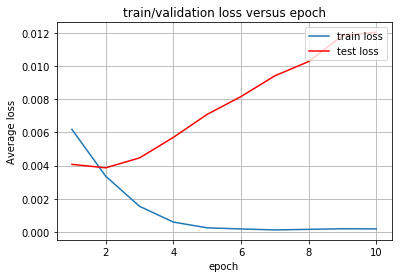

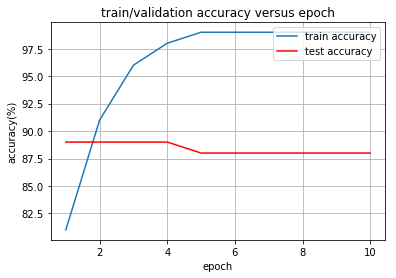

In [15]:
    #plot train/validation loss versus epoch
    x = list(range(1, 10+1))
    plt.figure()
    plt.title("train/validation loss versus epoch")
    plt.xlabel("epoch")
    plt.ylabel("Average loss")
    plt.plot(x, train_loss,label="train loss")
    plt.plot(x, test_loss, color='red', label="test loss")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
    #plot train/validation accuracy versus epoch
    x = list(range(1, 10+1))
    plt.figure()
    plt.title("train/validation accuracy versus epoch")
    plt.xlabel("epoch")
    plt.ylabel("accuracy(%)")
    plt.plot(x, train_acc,label="train accuracy")
    plt.plot(x, test_acc, color='red', label="test accuracy")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()